In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import cytnx
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt

MKL interface code: 1 >> using [ilp64] interface


# Time evolve an MPS by time-evolution block-decimation (TEBD)
#### Consider a Hamiltonian that contains only two-site terms
#### $$ \hat{H} = \sum_{i=1}^{N-1} \hat{\mathcal{H}}_{i,i+1}. $$
#### The time-evolution operator $e^{-i\delta_t\hat{H}}$ for a small time step $\delta_t$ can be approximately decomposed to
#### $$ e^{-2i\delta_t\hat{H}} \approx
        \left[ e^{-i\delta_t\hat{\mathcal{H}}_{1,2}} e^{-i\delta_t\hat{\mathcal{H}}_{2,3}} \cdots e^{-i\delta_t\hat{\mathcal{H}}_{N-1,N}} \right]
        \left[e^{-i\delta_t\hat{\mathcal{H}}_{N-1,N}} \cdots e^{-i\delta_t\hat{\mathcal{H}}_{2,3}} e^{-i\delta_t\hat{\mathcal{H}}_{1,2}} \right]
        + \mathcal{O}(\delta_t^3),$$
#### where each $e^{-i\delta_t\hat{\mathcal{H}}_{i,i+1}}$ is a two-site operator.


## Baker–Campbell–Hausdorff formula
#### To solve $e^Xe^Y=e^Z$
#### We arrive at the formula
$$Z=X+Y+\frac{1}{2}[X,Y]+\frac{1}{12}[X,[X,Y]]-\frac{1}{12}[Y,[X,Y]]+...$$
#### Which means $Z\approx X+Y+O([X,Y])$
#### In the case of TEBD, we have $Z=-i\delta_t\hat{H}_{i,i+1}-i\delta_t\hat{H}_{i+1,i+2}$
$$Z\approx -i\delta_t\hat{H}_{i,i+1}-i\delta_t\hat{H}_{i+1,i+2}+O(\delta_t^2)$$
#### This is called first order TEBD
#### When evolute time interval $T$, there're $\frac{T}{\delta_t}$ slices, the error accumulate to $\frac{T}{\delta_t}O(\delta_t^2)=O(\delta_t)$
#### We further decompose, define $$Z=-i\frac{\delta_t}{2}\hat{H}_{i,i+1}-i\frac{\delta_t}{2}\hat{H}_{i+1,i+2}-i\frac{\delta_t}{2}\hat{H}_{i+1,i+2}-i\frac{\delta_t}{2}\hat{H}_{i,i+1}$$
#### The error reduced to $O(\delta_t^3)$, accumulated error $O(\delta_t^2)$, i.e.
$$ e^{-2i\delta_t\hat{H}} \approx
        \left[ e^{-i\delta_t\hat{\mathcal{H}}_{1,2}} e^{-i\delta_t\hat{\mathcal{H}}_{2,3}} \cdots e^{-i\delta_t\hat{\mathcal{H}}_{N-1,N}} \right]
        \left[e^{-i\delta_t\hat{\mathcal{H}}_{N-1,N}} \cdots e^{-i\delta_t\hat{\mathcal{H}}_{2,3}} e^{-i\delta_t\hat{\mathcal{H}}_{1,2}} \right]
        + \mathcal{O}(\delta_t^3),$$

## 1. Define the time-evolution operators

### 1.1 Define operators
#### $$ \hat{S}^{z}=\left[\begin{array}{cc}
1 & 0\\
0 & -1
\end{array}\right]
, \qquad
\hat{S}^{x}=\left[\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}\right]
, \qquad
\hat{I}=\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
$$

In [3]:
Sx = 2*cytnx.physics.spin(0.5,'x').real()      # Sx
Sz = 2*cytnx.physics.spin(0.5,'z').real()      # Sz
I = cytnx.eye(2)                               # Identity operator

### 1.2 Define time-evolution operator $e^{-i\delta_t\hat{\mathcal{H}}_{i,i+1}}$

#### We consider transverse-field Ising model
#### $$ \begin{aligned}
H &= -J\sum_{i=1}^{N-1} \hat{S}^x_i\hat{S}^x_{i+1} - h_x\sum_{i=1}^N \hat{S}^z_i\\
&= \sum_{i=1}^{N-1} \hat{\mathcal{H}}_{i,i+1},
\end{aligned}$$
#### where $$ \mathcal{\hat{H}}_{i,i+1}=-J\hat{S}_{i}^{x}\hat{S}_{i+1}^{x}-h_{x}\begin{cases}
\hat{S}_{i}^{z} & ,i\neq N-1\\
\left(\hat{S}_{i}^{z}+\hat{S}_{i+1}^{z}\right) & ,i=N-1.
\end{cases}$$
#### The operator $e^{-i\delta_t\hat{\mathcal{H}}_{i,i+1}}$ can be constructed as follows.

In [4]:
# Define time-evolution (two-site) gates
def get_gates (Nsites, dt, J, hz, imag=False):
    if not imag:
        dt *= 1j
    
    # Define two-site operators
    
    # Kron is the Kronecker products
    # For example, with shape(T1)=(s1,s2), shape(T2)=(s3,s4)
    # Kron(Tensor::T1,Tensor::T2) will return tensor with shape=(s1,s2,s3,s4)
    # With the tensor element size s1*s2*s3*s4
    Sxx = cytnx.linalg.Kron(Sx,Sx)                             # Sx⊗Sx
    Sz1 = cytnx.linalg.Kron(Sz,I)                              # Sz⊗I
    Sz2 = cytnx.linalg.Kron(Sz,I) + cytnx.linalg.Kron(I,Sz)    # Sz⊗Sz
    
    gates = []
    for i in range(Nsites-1):
        # Define two-site Hamiltonian H_{i,i+1}
        if i != Nsites-2:
            H = -hz*Sz1 - J*Sxx                   # Not the last link
        else:
            H = -hz*Sz2 - J*Sxx                   # The last link
        
        # Compute exp(H_{i,i+1})
        expH = cytnx.linalg.ExpM(-dt*H)       # Do the exp(-i*dt*H) by Cytnx
        #    |           |         
        #   (0)         (1)         row 
        #    |           |
        #  |---------------|       
        #  |      expH     |
        #  |---------------|      
        #    |           |         
        #   (2)         (3)         column
        #    |           | 
        expH.reshape_(2,2,2,2) # Reshape it to a two-site gate (with 4 indices)
        expH = cytnx.UniTensor(expH, rowrank=2)   # Convert it to a UniTensor
        gates.append(expH)                        # Store the gate
    return gates

### 1.3 Define the operation of applying a gate

In [5]:
def evolve_psi (expH, psi):
    # Define the network for the contraction
    anet = cytnx.Network()
    #          |---------------|       
    #   -(-4)--|      expH     |--(-5)-
    #          |---------------|                   (-4) (-5)
    #            |           |                       |   |
    #           (0)         (1)          -->        |-----|
    #            |           |                 (2)--| OUT |--(3)
    #          |---------------|                    |-----|
    #   --(2)--|      psi      |--(3)--
    #          |---------------|
    anet.FromString(["expH: 0,1,-4,-5",
                     "psi: 2,0,1,3",
                     "TOUT: 2,-4;-5,3"])
    # TOUT: 2,-4;-5,3 means: bonds(2,-4) belongs to row,
    # while bonds(-5,3) belongs to column

    anet.PutUniTensors(["expH","psi"], [expH, psi])
    lbl = psi.labels()
    evolved_psi = anet.Launch()
    
    # Retrive original labels
    evolved_psi.set_labels(lbl)
    return evolved_psi

## 2. Initialize MPS

### 2.1 Initialize MPS as a product state
### $$ |\psi\rangle = |\uparrow\uparrow\uparrow\uparrow\cdots\downarrow\downarrow\downarrow\downarrow\cdots\rangle$$

In [6]:
# Initialize MPS
def get_init_MPS (Nsites):
    d = 2             # Physical dimension
    psi = [None for i in range(Nsites)]
    for i in range(Nsites):
        #         (dim=d)
        #            |
        # --(dim=1)--A--(dim=1)--
        A = cytnx.zeros([1,d,1])
        # First half with up spin, half with down
        if i < Nsites//2:
            A[0,1,0] = 1
        else:
            A[0,0,0] = 1
        psi[i] = cytnx.UniTensor (A, rowrank=2)
        #          (label=2*i+1)
        #                |
        # --(label=2*i)--A--(label=2*i+2)--
        psi[i].set_labels([str(2*i),str(2*i+1),str(2*i+2)])
    return psi

## 3. Define functions for measurements

### 3.1 Concept of Orthogonality Center
#### To reduce the computational complexity & truncate the bond dimension, we want to decompose tensors into this form.
#### This can be done by doing svd, as you can see later
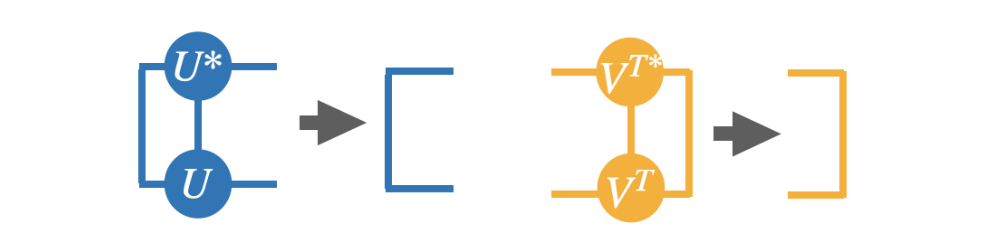

### 3.2 On-site measurements
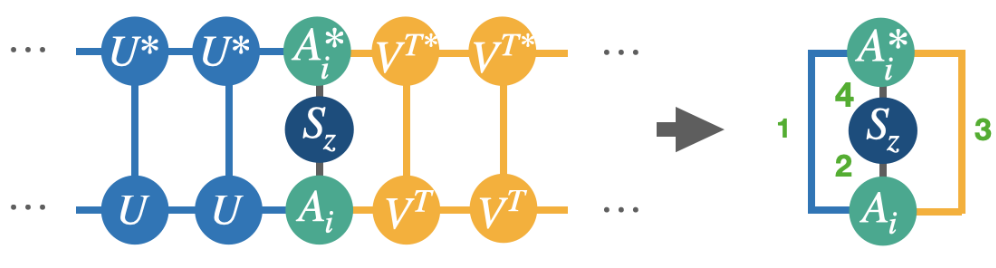

In [7]:
# Measure the on-site operator <op>
# The input MPS tensor <A> must be the orthogonality-center tensor
def measure_onsite (A, op):
    Op = cytnx.UniTensor (op, rowrank=1)

    anet = cytnx.Network()
    anet.FromString(["A: 1,2,3",
                     "Z: 2,4",
                     "Aconj: 1,4,3",
                     "TOUT:;"])
    anet.PutUniTensors (["Z","A","Aconj"],[Op, A, A.Conj()])
    obs = anet.Launch().get_block().item()
    if type(obs) == complex:
        obs = obs.real
    return obs

### 3.3 Two-site measurements
<img src="figures/two_site_mea.png" alt="drawing" width="600"/>

In [8]:
# Measure the on-site operator <op>
# One of the input MPS tensor <A1> or <A2> must be the orthogonality-center tensor
def measure_twosite (A1, A2, op):
    Op = cytnx.UniTensor (op, rowrank=1)

    anet = cytnx.Network()
    anet.FromString(["AA: 1,2,3,4",\
                     "O: 2,3,5,6",\
                     "AA_Conj: 1,5,6,4",\
                     "TOUT:;"])
    AA = cytnx.Contract(A1,A2)
    AA_Conj = cytnx.Contract(A1.Conj(),A2.Conj())
    anet.PutUniTensors(["AA","O","AA_Conj"],[AA, op, AA_Conj])
    
    # Observable
    obs = anet.Launch().get_block().real().item()              
    
    if type(obs) == complex:
        obs = obs.real
    return obs

## 4. Define TEBD loop

#### (Right to left)
#### The triangle tensors are in the canonical form
<img src="figures/tebd_sweep.png" alt="drawing" width="700"/>

In [9]:
def tebd (psi, J, hz, dt, steps, maxdim, cutoff, Nsites, imag_time=False):
    # Parameters
    # psi:        Initial MPS
    # J:          Sx⊗Sx coupling
    # hz:         Transverse field
    # dt:         Time step
    # steps:      Number of time steps
    # maxdim:     Maximal kept dimension when doing SVD
    # cutoff:     Cutoff for the singular values when doing SVD
    # Nsites:     Number of MPS sites
    # imag_time:  Real or imaginary time evolution

    # Define the bonds for left-to-right and right-to-left sweeps
    sweeps_bonds = [range(Nsites-1), range(Nsites-2,-1,-1)]

    # Get the time-evolution gates
    expHs = get_gates (Nsites, dt, J, hz, imag=imag_time)

    # To store the on-site observables
    szs = np.full ((steps,Nsites),np.nan)
    sxs = np.full ((steps,Nsites),np.nan)
    maxdims = np.full (steps,np.nan)
    
    # TEBD sweeps
    for step in range(steps):
        print ('step',step,end="")
        for lr in [0,1]:
            for p in sweeps_bonds[lr]:
                # Compute psi for the bond
                AA = cytnx.Contract (psi[p], psi[p+1])
                AA.set_rowrank(2)
                # Apply gate to psi
                evolved_psi = evolve_psi (expHs[p], AA)

                # SVD and truncate psi to MPS tensors
                s, psi[p], psi[p+1] = cytnx.linalg.Svd_truncate (evolved_psi, keepdim=maxdim, err=cutoff)
                # Normalize the singular values
                s = s/s.get_block_().Norm().item()

                # Relable tensors so that labels won't duplicate
                # when executing next svd truncate
                s.set_labels(["_aux_L"+str(p),"_aux_R"+str(p+1)])
                psi[p].set_label("_aux_L","_aux_L"+str(p))
                psi[p+1].set_label("_aux_R","_aux_R"+str(p+1))
                
                # Absorb the singular-value tensor into the left/right site
                if lr == 0:
                    psi[p+1] = cytnx.Contract (s,psi[p+1])
                else:
                    psi[p] = cytnx.Contract (psi[p],s)

                # Measure
                if lr == 0 and p == Nsites-2:
                    A = psi[Nsites-1]
                    szs[step,Nsites-1] = measure_onsite (A, Sz)
                    sxs[step,Nsites-1] = measure_onsite (A, Sx)
                if lr == 1:
                    szs[step,p] = measure_onsite (psi[p], Sz)
                    sxs[step,p] = measure_onsite (psi[p], Sx)
        # Compute the maximal bond dimension for the MPS
        maxm = 0
        for p in range(Nsites):
            # psi[p].shape()[1] is physical bond
            #         (phy)
            #           |
            # --(vir)--psi--(vir)--
            maxm = max(psi[p].shape()[0], psi[p].shape()[2], maxm)
        maxdims[step] = maxm
        print (', max dim='+str(maxm),end="\n")
    return psi, szs, sxs, maxdims

## 5. Compute the ground state by imaginary time evolution
#### (Compare with DMRG)

In [10]:
Nsites = 20             # Number of sites
dt = 0.2

psi = get_init_MPS (Nsites)
psi, szs, sxs, dims = tebd (psi, J=1, hz=0.5, dt=dt, steps=10, maxdim=200,
                            cutoff=1e-6, imag_time=True, Nsites=Nsites)

step 0, max dim=4
step 1, max dim=6
step 2, max dim=8
step 3, max dim=8
step 4, max dim=8
step 5, max dim=10
step 6, max dim=10
step 7, max dim=10
step 8, max dim=10
step 9, max dim=10


## 6. Compute time-evolved state by real-time evolution

### 6.1 Compute time evolution

In [11]:
Nsites = 20
dt = 0.05

psi = get_init_MPS (Nsites)
psi, szs, sxs, dims = tebd (psi, J=1, hz=10, dt=dt, steps=40, maxdim=200,
                            cutoff=1e-6, Nsites=Nsites)

step 0, max dim=4
step 1, max dim=5
step 2, max dim=6
step 3, max dim=6
step 4, max dim=8
step 5, max dim=8
step 6, max dim=8
step 7, max dim=9
step 8, max dim=10
step 9, max dim=10
step 10, max dim=11
step 11, max dim=12
step 12, max dim=13
step 13, max dim=15
step 14, max dim=15
step 15, max dim=15
step 16, max dim=16
step 17, max dim=16
step 18, max dim=18
step 19, max dim=19
step 20, max dim=21
step 21, max dim=21
step 22, max dim=22
step 23, max dim=24
step 24, max dim=24
step 25, max dim=26
step 26, max dim=27
step 27, max dim=28
step 28, max dim=29
step 29, max dim=32
step 30, max dim=32
step 31, max dim=34
step 32, max dim=34
step 33, max dim=38
step 34, max dim=40
step 35, max dim=42
step 36, max dim=42
step 37, max dim=44
step 38, max dim=45
step 39, max dim=46


### 6.2 Save the data to .npy

In [12]:
# As for now, cytnx and matplotlib are not compatible,
# thus we need to save the file first, then plot
np.save('datas/tebd_dt',dt)
np.save('datas/tebd_szs',szs)
np.save('datas/tebd_sxs',sxs)

## 7. Global measurement $\langle\psi|\hat{H}|\psi\rangle$ (optional)
<img src="figures/total_mea.png" alt="drawing" width="500"/>

In [13]:
# Measure <psi|H|psi>, where psi and H are an MPS and an MPO
# A: An array of MPS tensors
# M: A MPO tensor
def getTotalE (A, M):
    D_MPO = M.shape()[0]             # MPO bond dimension
    # Left boundary
    L = cytnx.UniTensor (cytnx.zeros([D_MPO,1,1]), rowrank=1)   
    L.get_block_()[D_MPO-1,0,0] = 1.
    # Right boundary
    R0 = cytnx.UniTensor (cytnx.zeros([D_MPO,1,1]), rowrank=1)  
    R0.get_block_()[0,0,0] = 1.

    anet = cytnx.Network()
    anet.FromString(["L: -2,-1,-3",
                     "A: -1,-4,1",
                     "M: -2,0,-4,-5",
                     "A_Conj: -3,-5,2",
                     "TOUT: 0;1,2"])
    # Contract the tensors from left to right
    for p in range(Nsites):
        A[p].set_rowrank_(2)
        anet.PutUniTensors(["L","A","A_Conj","M"],[L,A[p],A[p].Conj(),M])
        L = anet.Launch()
    # Contract with the right boundary tensor to get the energy
    anet = cytnx.Network()
    anet.FromString(["L: -2,-1,-3",
                     "R0: -2,-1,-3",
                     "TOUT:;"])
    anet.PutUniTensors(["L","R0"],[L,R0])
    E = anet.Launch().get_block().item()
    if type(E) == complex:
        E = E.real
    return E

### 7.1 Define Hamiltonian MPO
#### (Just for measuring energy)

#### MPO tensor
#### $$\hat{H} = L_0 M_1 M_2 \cdots M_N R_0,$$
#### $$
L_{0}=\left[\begin{array}{ccc}
0 & 0 & 1\end{array}\right]
, \qquad
M_i=\left[\begin{array}{ccc}
\hat{I_i}\\
\hat{S}^{x}_i & 0\\
-h_{z}\hat{S}^{z}_i & -\hat{S}^{x}_i & \hat{I}_i
\end{array}\right]
, \qquad
R_{0}=\left[\begin{array}{c}
1\\
0\\
0
\end{array}\right]
$$

In [14]:
# Define TFIM MPO (Matrix Product Operator)
# To understand how to automatically define the MPO, see 10.21468/SciPostPhys.3.5.035
# or 10.1103/PhysRevB.95.035129
def TFIM_MPO_tensor (J, hz, hx):
    d = 2                                      # Physical dimension
    dM = 3                                     # MPO bond dimension
    M = cytnx.zeros([dM, dM, d, d])
    M[0,0] = I
    M[2,2] = I
    M[1,0] = Sx
    M[2,1] = -J*Sx
    M[2,0] = -hz*Sz - hx*Sx
    M = cytnx.UniTensor (M, rowrank=2)
    return M

### 7.2 Define revised version of TEBD

In [15]:
def tebd (psi, J, hz, dt, steps, maxdim, cutoff, Nsites, imag_time=False):
    # Parameters
    # psi:        Initial MPS
    # J:          Sx.Sx coupling
    # hz:         Transverse field
    # dt:         Time step
    # steps:      Number of time steps
    # maxdim:     Maximal kept dimension when doing SVD
    # cutoff:     Cutoff for the singular values when doing SVD
    # Nsites:     Number of MPS sites
    # imag_time:  Real or imaginary time evolution

    # Define the bonds for left-to-right and right-to-left sweeps
    sweeps_bonds = [range(Nsites-1), range(Nsites-2,-1,-1)]

    # Get the time-evolution gates
    expHs = get_gates (Nsites, dt, J, hz, imag=imag_time)

    # Make MPO tensor (for measuring the total energy)
    M = TFIM_MPO_tensor (J, hz, hx=0)

    # To store the on-site observables
    szs = np.full ((steps,Nsites),np.nan)
    sxs = np.full ((steps,Nsites),np.nan)
    maxdims = np.full (steps,np.nan)
    
    # TEBD sweeps
    for step in range(steps):
        print ('step',step,end="")
        for lr in [0,1]:
            for p in sweeps_bonds[lr]:
                
                # Compute psi for the bond
                AA = cytnx.Contract (psi[p], psi[p+1])
                AA.set_rowrank(2)
                # Apply gate to psi
                evolved_psi = evolve_psi (expHs[p], AA)

                # SVD and truncate psi to MPS tensors
                s, psi[p], psi[p+1] = cytnx.linalg.Svd_truncate (evolved_psi, keepdim=maxdim, err=cutoff)
                # Normalize the singular values
                s = s/s.get_block_().Norm().item()
                
                # Relable tensors so that labels won't duplicate
                # when executing next svd truncate
                s.set_labels(["_aux_L"+str(p),"_aux_R"+str(p+1)])
                psi[p].set_label("_aux_L","_aux_L"+str(p))
                psi[p+1].set_label("_aux_R","_aux_R"+str(p+1))
                
                # Absorb the singular-value tensor into the left/right site
                if lr == 0:
                    psi[p+1] = cytnx.Contract (s,psi[p+1])
                else:
                    psi[p] = cytnx.Contract (psi[p],s)

                # Measure
                if lr == 0 and p == Nsites-2:
                    A = psi[Nsites-1]
                    szs[step,Nsites-1] = measure_onsite (A, Sz)
                    sxs[step,Nsites-1] = measure_onsite (A, Sx)
                if lr == 1:
                    szs[step,p] = measure_onsite (psi[p], Sz)
                    sxs[step,p] = measure_onsite (psi[p], Sx)
        # Compute the maximal bond dimension for the MPS
        maxm = 0
        for p in range(Nsites):
            maxm = max(psi[p].shape()[0], psi[p].shape()[2], maxm)
        maxdims[step] = maxm
        print (', max dim='+str(maxm),end="")

        # Compute the total energy
        print (", total E=", getTotalE (psi,M))
    return psi, szs, sxs, maxdims

## Homework 1.
Try simulating the real time evolution of the TFIM Hamitonian with $h_z = 0$ and $h_z = 0.5$, record the **entanglement entropy** during the evolution and **plot it as a function of time**.

## Homework 2.
Instead of the domain wall product state
$$ |\psi\rangle = |\uparrow\uparrow\uparrow\uparrow\cdots\downarrow\downarrow\downarrow\downarrow\cdots\rangle$$
Try using the TFIM Hamiltonian with arbitary $h_z$ to evolve a **"local defect"** product state:
$$ |\psi\rangle = |\cdots\uparrow\uparrow\uparrow\uparrow\downarrow\uparrow\uparrow\uparrow\uparrow\cdots\rangle$$
(which is a all spin up state with the spin in the center flipped)  
**Plot the result of $\langle S_z \rangle$ as a function of time and sites.**


## Homework 3.
Start with the groundstate of TFIM Hamiltonian at $h_z = 10$, perform the real time evolution with $h_z = 3$ and plot the $\langle S_z(t) \rangle$ (you average all the sites), see if you can reproduce an **oscillating curve**.

